# Report: Navigation with a DQN Agent

### Project Overview

The goal of this project is to train a reinforcement learning agent to navigate a 3D environment and collect bananas. The agent must learn a policy to maximize its score by collecting yellow bananas (reward +1) and avoiding blue bananas (reward -1).

This task is solved using a **Deep Q-Network (DQN)**. The standard DQN algorithm is enhanced with **Prioritized Experience Replay (PER)**, a technique that allows the agent to learn more efficiently from its experiences. The environment is considered "solved" when the agent achieves an average score of **+13 over 100 consecutive episodes**.

## Learning Algorithm

The agent is trained using a **Deep Q-Network (DQN)**. The implementation includes several key enhancements to the original algorithm to improve learning stability and sample efficiency, most notably **Fixed Q-Targets** and **Prioritized Experience Replay (PER)**.

### Key Concepts

1.  **Deep Q-Network (DQN)**: The core of the agent is a neural network that approximates the optimal action-value function, `Q*(s, a)`. This network takes the state (37 dimensions) as input and outputs a Q-value for each of the 4 possible discrete actions.

2.  **Fixed Q-Targets**: To stabilize learning, two separate neural networks are used: a **local network** that is updated at every learning step and a **target network** that is updated less frequently. The target network is used to calculate the TD (Temporal Difference) target for the Bellman update. This separation provides a more stationary target, preventing the feedback loops that can cause Q-learning updates to diverge. The target network's weights are slowly adjusted to match the local network's weights via a "soft update" (`θ_target = τ*θ_local + (1-τ)*θ_target`).

3.  **Prioritized Experience Replay (PER)**: This is a key enhancement over the standard experience replay. Instead of sampling experiences uniformly from the replay buffer, PER samples experiences based on their importance, which is measured by the magnitude of their TD error.
    *   **How it works**: Experiences with high TD error are those where the agent's prediction was very wrong, meaning there is a lot to learn from them. By replaying these "surprising" experiences more frequently, the agent can learn more efficiently.
    *   **Implementation**: A **Fenwick Tree** is used for efficient priority-based sampling. To correct for the bias introduced by this non-uniform sampling, **Importance Sampling (IS) weights** are used to scale the loss for each sampled experience.

4.  **Epsilon-Greedy Action Selection**: To balance exploration and exploitation, the agent uses an epsilon-greedy policy. The value of `ε` (the probability of taking a random action) is annealed from `1.0` down to `0.05`. This decay happens over the first 70% of the total training episodes, after which the agent acts mostly greedily.

### Model Architecture

The Q-Network is a fully-connected neural network (MLP) with the following structure:
*   **Input Layer**: 37 units (State Size)
*   **Hidden Layer**: 256 units (with ReLU activation)
*   **Output Layer**: 4 units (Action Size), representing the Q-value for each action.

### Hyperparameters

The final hyperparameters used for the successful training run are listed below.

| Hyperparameter      | Value         | Description                                                        |
| ------------------- | ------------- | ------------------------------------------------------------------ |
| `BUFFER_SIZE`       | 1e6           | Replay buffer size                                                 |
| `BATCH_SIZE`        | 256           | Minibatch size for training                                        |
| `GAMMA`             | 0.99          | Discount factor for future rewards                                 |
| `TAU`               | 1e-3          | For soft update of target network parameters                       |
| `LR`                | 1e-4          | Learning rate of the Adam optimizer                                |
| `UPDATE_EVERY`      | 4             | Frequency of network updates (in time steps)                       |
| `EPSILON_BOUNDS`    | (0.05, 1.0)   | Min and max values for epsilon in epsilon-greedy policy            |
| `ANNEAL_ENDPOINT`   | 0.7           | Fraction of total episodes over which to anneal epsilon            |
| `ALPHA`             | 0.6           | PER: Controls prioritization (0=uniform, 1=full)                   |
| `BETA_BOUNDS`       | (0.4, 1.0)    | PER: Min and max values for IS weight exponent `beta`              |
| `n_episodes`        | 1000          | Maximum number of training episodes                                |

# Navigation

### 0. Prerequisites

Follow environment creation and dependecy installation guidelines from the README.md file

### 1. Start the Environment

In [1]:
%cd ../../

/Users/olehborovyk/Code/drlnd


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch, os

In [3]:
torch.set_num_threads(4)
torch.set_num_interop_threads(1)
os.environ["OMP_NUM_THREADS"] = "4"

In [4]:
path = os.path.join(os.getcwd(), "DeepRL", "DQN", "Banana.app")
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. DQN Training

In [7]:
import random
import torch
import time
import numpy as np
from tqdm import tqdm
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from DeepRL.DQN.dqn import Agent

In [8]:
agent = Agent(
        state_size=state_size,
        action_size=action_size,
        random_seed=42,
    
        buffer_size=int(1e6),
        batch_size=256,
        gamma=0.99,
        tau=1e-3,
    
        lr=1e-4,
        epsilon_bounds=(0.05, 1.0),
        anneal_endpoint=0.7,
        update_every=4,
    
        # PER parameters
        alpha=0.6,
        beta_bounds=(0.4, 1.0),
    
)

n_episodes = 1000
avg_score_over_k_episodes = 100

In [9]:
scores_deque = deque(maxlen=avg_score_over_k_episodes)                       
all_scores = []
actions = []
max_score = -1

with tqdm(total=n_episodes) as pbar:
    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  
        agent.reset(progress=episode/n_episodes)
        
        states = env_info.vector_observations   
        episode_scores = np.zeros(num_agents)
        dones = [0]
        while not np.any(dones):
            action = agent.act(states[0])
            actions.append(action)
            env_info = env.step({brain_name: [action]})[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states[0], action, rewards[0], next_states[0], dones[0])

            episode_scores += rewards
            states = next_states

        scores_deque.extend(list(episode_scores))
        all_scores.extend(list(episode_scores))
        
        avg_score = np.mean(scores_deque)
        
        if episode % avg_score_over_k_episodes == avg_score_over_k_episodes-1:
            print(f"Avg. score over last {avg_score_over_k_episodes} episodes: {avg_score:.3f}")
        pbar.set_postfix({"Ep. score": f"{episode_scores[0]:.3f}"})
        pbar.update(1)
        
        if avg_score >= 13.0 and episode >= avg_score_over_k_episodes:
            if max_score < 13.0:
                print(f"PROBLEM SOLVED! Achieved {avg_score:.4f} score over the last 100 episodes")
            if avg_score > max_score:
                max_score = avg_score
                torch.save(agent.qn_local.state_dict(), os.path.join(os.getcwd(), "DeepRL", "DQN", 'checkpoint_qn_local.pth'))
                torch.save(agent.qn_target.state_dict(), os.path.join(os.getcwd(), "DeepRL", "DQN", 'checkpoint_qn_target.pth'))
            if max_score > 15.0:
                print(f"Early stop at episode {episode}")
                break
env.close()

 10%|█         | 100/1000 [01:19<11:59,  1.25it/s, Ep. score=0.000]

Avg. score over last 100 episodes: 0.080


 20%|██        | 200/1000 [02:40<10:49,  1.23it/s, Ep. score=3.000] 

Avg. score over last 100 episodes: 0.460


 30%|███       | 300/1000 [04:03<09:42,  1.20it/s, Ep. score=-1.000]

Avg. score over last 100 episodes: 2.280


 40%|████      | 400/1000 [05:26<08:14,  1.21it/s, Ep. score=8.000] 

Avg. score over last 100 episodes: 6.580


 50%|█████     | 500/1000 [06:49<06:53,  1.21it/s, Ep. score=12.000]

Avg. score over last 100 episodes: 9.530


 60%|██████    | 600/1000 [08:15<05:53,  1.13it/s, Ep. score=11.000]

Avg. score over last 100 episodes: 10.920


 70%|███████   | 700/1000 [09:44<04:29,  1.11it/s, Ep. score=18.000]

Avg. score over last 100 episodes: 12.280


 77%|███████▋  | 772/1000 [10:50<03:27,  1.10it/s, Ep. score=20.000]

PROBLEM SOLVED! Achieved 13.0200 score over the last 100 episodes


 80%|████████  | 800/1000 [11:15<03:01,  1.10it/s, Ep. score=14.000]

Avg. score over last 100 episodes: 13.470


 90%|█████████ | 900/1000 [12:50<01:44,  1.05s/it, Ep. score=17.000]

Avg. score over last 100 episodes: 13.060


100%|██████████| 1000/1000 [14:22<00:00,  1.16it/s, Ep. score=6.000]

Avg. score over last 100 episodes: 14.460


## 4. Results

The DQN agent with Prioritized Experience Replay successfully solved the environment.

The environment was solved in 772 episodes, achieving the target average score of +13 over 100 consecutive episodes.

The plot below illustrates the agent's performance during training. The score per episode (blue) shows significant variance, which is typical for RL tasks. However, the 100-episode moving average (orange) demonstrates a clear and steady learning trend, eventually surpassing the +13 goal (red dashed line) and continuing to improve.

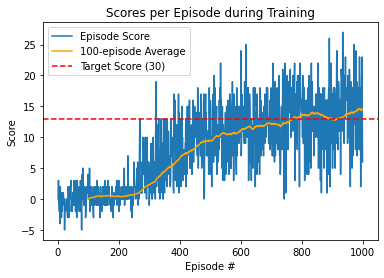

In [10]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores, label='Episode Score')
# Add a 100-episode moving average
rolling_mean = pd.Series(all_scores).rolling(avg_score_over_k_episodes).mean()
plt.plot(rolling_mean, label='100-episode Average', color='orange')
plt.axhline(y=13, color='r', linestyle='--', label='Target Score (30)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Scores per Episode during Training')
plt.legend()
plt.show()

## 5. Ideas for Future Work

While the agent was successful, its performance could be further improved by exploring several advanced techniques from the DQN literature:

1.  **Double DQN (DDQN)**: The standard DQN algorithm is known to suffer from an overestimation of Q-values. DDQN addresses this by decoupling the action selection from the target Q-value calculation. The local network is used to select the best action, but the target network is used to evaluate the Q-value of that action. This simple change often leads to more stable training and better final performance.

2.  **Dueling DQN**: This architectural change splits the Q-network into two streams: one that estimates the state-value function `V(s)` and another that estimates the advantage function `A(s, a)` for each action. These are then combined to produce the final Q-values. This allows the network to learn which states are valuable without having to learn the effect of each action in those states.

3.  **Rainbow DQN**: Combine multiple DQN improvements (DQN, DDQN, Dueling, PER, etc.) into a single agent. Research has shown that these enhancements are largely complementary and result in a significantly more powerful agent.

4.  **Noisy Nets for Exploration**: Instead of using epsilon-greedy, noise can be added to the weights of the network's final layers. This creates a state-dependent exploration strategy that can be more effective, as the agent can learn to explore more in uncertain parts of the state space.

## 6. Inference

In [1]:
%cd ../../

/Users/olehborovyk/Code/drlnd


In [2]:
# --- NOTE ---
# You may need to restart the kernel and re-run the environment setup cell
# before executing the inference code below.

from unityagents import UnityEnvironment
import torch, os
import numpy as np
from DeepRL.DQN.dqn import Agent

# Re-initialize environment
path = os.path.join(os.getcwd(), "DeepRL", "DQN", "Banana.app")
env = UnityEnvironment(file_name=path)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]

# Get environment parameters
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
num_agents = len(env_info.agents)

# Initialize a new agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=43, epsilon_bounds=[0.05,0.05])

# Load the trained weights
agent.qn_local.load_state_dict(torch.load(os.path.join(os.getcwd(), "DeepRL", "DQN", 'checkpoint_qn_local.pth')))

scores = np.zeros(num_agents)
while True:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break

print('Total score this episode: {}'.format(np.mean(scores)))

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Total score this episode: 11.0
